In [1]:
import pandas as pd

df = pd.read_csv("data/spam.csv", encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [28]:
df.shape

(5572, 3)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   label          0 non-null      float64
 1   message        5572 non-null   object 
 2   clean_message  5572 non-null   object 
dtypes: float64(1), object(2)
memory usage: 130.7+ KB


In [2]:
df['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

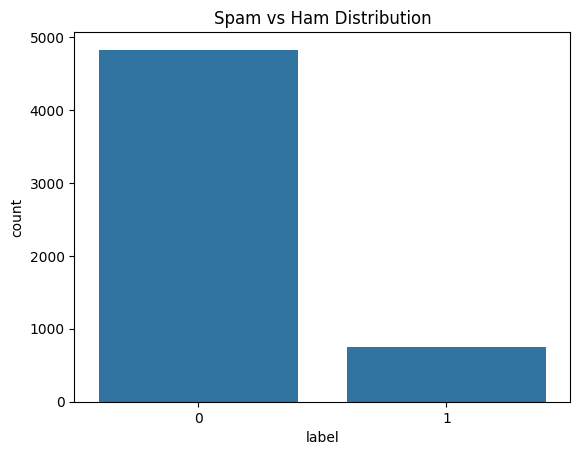

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=df)
plt.title("Spam vs Ham Distribution")
plt.show()
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [27]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['clean_message'] = df['message'].apply(preprocess)


[nltk_data] Downloading package stopwords to C:\Users\Noman
[nltk_data]     Traders\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Noman
[nltk_data]     Traders\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['clean_message'])
X


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 40239 stored elements and shape (5572, 3000)>

In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['label'])  # spam=1, ham=0
y

array([0, 0, 0, ..., 0, 0, 0], shape=(5572,))

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (4457, 3000)
Test set size: (1115, 3000)


In [25]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)


,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1115

    accuracy                           1.00      1115
   macro avg       1.00      1.00      1.00      1115
weighted avg       1.00      1.00      1.00      1115



c:\Users\Noman Traders\Documents\GitHub\spam-classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:620: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


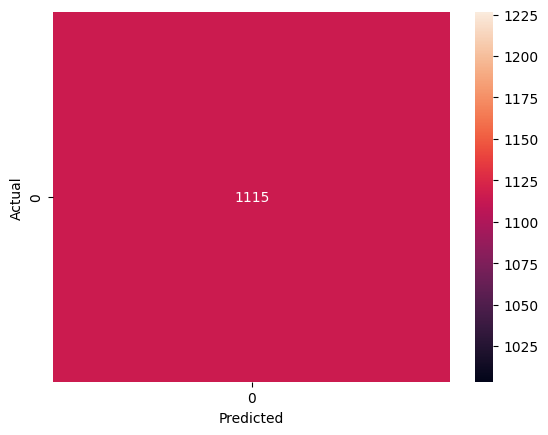

In [13]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [14]:
def predict_spam(text):
    text = preprocess(text)
    vector = vectorizer.transform([text])
    result = model.predict(vector)
    return "Spam" if result[0] == 1 else "Not Spam"

predict_spam("Congratulations! You won a free iPhone")


'Not Spam'

In [17]:
predict_spam("Hello, how are you doing today?")

'Not Spam'